**Proposta nova:**
- Uso de LLM para classificação
- Escrever o resto da proposta...

In [ ]:
# %pip install pandas
# %pip install matplotlib
# %pip install --upgrade numpy
# %pip install seaborn
# %pip install scikit-learn
# %pip install ipywidgets
# %pip install tensorflow
# %pip install --upgrade gensim
# %pip install python-dotenv
%pip install openai

---

### Activate venv:

In [8]:
## Activate python venv:

!python -m venv .venv
# Then, select the Jupyter kernel to use the venv, then execute the call below

^C


In [ ]:
%pip install -r requirements.txt

In [6]:
%pip install python-dotenv
%pip install openai

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/454.3 kB ? eta -:--:--
   ------ --------------------------------- 71.7/454.3 kB 2.0 MB/s eta 0:00:01
   --------------------------- ------------ 307.2/454.3 kB 3.8 MB/s eta 0:00:01
   ---------------------------------------- 454.3/454.3 kB 4.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/93.1 kB ? eta -:--:--
   ---------------------------------------- 93.1/93.1 kB 5.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/73.5 kB ? eta -:--:--
   ---------------------------------------- 73.5/73.5 kB ? eta 0:00:00
   ---------------------------------------- 0.0/78.6 kB ? eta -:--:--
   ---------------------------------------- 78.6/78.6 kB 4.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/206.7 kB ? eta -:--:--
   --------------------------------------- 206.7/206.7 kB 13.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/431.8 kB ? eta -:--:--
   ----------------------------


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


---

### Inicio | Imports

In [51]:
import pandas as pd
import os
from dotenv import load_dotenv
import requests
from openai import OpenAI
from IPython.display import clear_output
from pprint import pprint
from string import punctuation
import seaborn as sns
import matplotlib.pyplot as plt
import re 

load_dotenv()

OPENAI_PROJECT = os.getenv("OPENAI_PROJECT_ID")
OPENAI_APIKEY = os.getenv("OPENAI_APIKEY")

## Authenticate with OpenAI via CURL
# !curl https://api.openai.com/v1/models -H "Authorization: Bearer $OPENAI_APIKEY" -H "OpenAI-Project: $OPENAI_PROJECT"

# from sklearn.model_selection import train_test_split
# from keras.layers import TextVectorization
# from gensim import utils
# import gensim.models

# import numpy as np

%matplotlib inline

---
### Dataframe:

In [19]:
path = 'PolitenessDataset-FULL.csv'

# Original Dataframe
OriginalPolitenessDF = pd.read_csv(path)
# print('Data Stats:', OriginalPolitenessDF.describe())

# Experiments Dataframe
TargetDf = OriginalPolitenessDF.copy()

TargetDf.head(4)

,Venue,Review ID,review,Tone,Review URL
0,ShitMyReviewerSay,NaN,"It is early in the year, but difficult to imag...",2,NaN
1,ShitMyReviewerSay,NaN,You do not use the empirical data for the anal...,2,NaN
2,ShitMyReviewerSay,NaN,I understand that Wikipedia is not the best so...,3,NaN
3,ShitMyReviewerSay,NaN,Reviewer #1: 'The project can hardly be descri...,3,NaN


In [20]:
# Basic Transformations:

# Codificação
TargetDf['CodeVenue'] = TargetDf['Venue'].astype('category').cat.codes
# ReviewId
TargetDf['Index'] = TargetDf.index
# Reorder
TargetDf = TargetDf[['Index', 'CodeVenue', 'review', 'Tone']]
TargetDf.head()

,Index,CodeVenue,review,Tone
0,0,3,"It is early in the year, but difficult to imag...",2
1,1,3,You do not use the empirical data for the anal...,2
2,2,3,I understand that Wikipedia is not the best so...,3
3,3,3,Reviewer #1: 'The project can hardly be descri...,3
4,4,3,The figures are dishonest and not all that use...,2


---
### Pre Processamento:

In [30]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [40]:
# # Identificar linhas onde o tipo não é string
# non_string_rows = TargetDf[~TargetDf['raw_review'].apply(lambda x: isinstance(x, str))]

# # Exibir as linhas com valores não string
# print(non_string_rows)

TargetDf[~TargetDf['raw_review'].apply(lambda x: isinstance(x, str))]

,Index,CodeVenue,raw_review,Tone
2356,2356,2,NaN,3


In [42]:
def ReviewPreProcess(x: str):
    '''
    Esta função realiza:
    - Conversão para string
    - Remoção de Pontuação
    - Tudo minusculo
    - Remoção de links
    - Remoção de menções
    - Remoção de palavras com números
    - Normalização de espaços
    '''
    
    # Converter para string, caso não seja
    if not isinstance(x, str):
        return ''  # Retorna string vazia para entradas inválidas
    
    new_x = x
    for c in punctuation:
        new_x = new_x.replace(c,'')
    pattern = r"""
    http\S+|         # Remove links
    @\w+|            # Remove mentions
    \b\w*\d\w*\b|    # Remove words containing numbers
    \s+              # Normalize spaces
    """    
    new_x = re.sub(pattern, ' ', new_x, flags=re.VERBOSE) #removendo pontuação do texto
    return new_x.lower().strip()

# TargetDf.rename(columns={'review': 'raw_review'}, inplace=True)
TargetDf['transformed_review'] = TargetDf['raw_review'].apply(ReviewPreProcess)
TargetDf

,Index,CodeVenue,raw_review,Tone,transformed_review
0,0,3,"It is early in the year, but difficult to imag...",2,it is early in the year but difficult to imagi...
1,1,3,You do not use the empirical data for the anal...,2,you do not use the empirical data for the anal...
2,2,3,I understand that Wikipedia is not the best so...,3,i understand that wikipedia is not the best so...
3,3,3,Reviewer #1: 'The project can hardly be descri...,3,reviewer the project can hardly be described...
4,4,3,The figures are dishonest and not all that use...,2,the figures are dishonest and not all that useful
...,...,...,...,...,...
2495,2495,3,The scientific contribution of this paper - if...,2,the scientific contribution of this paper if t...
2496,2496,3,Reviewer 2: The proposal is also poorly writte...,2,reviewer the proposal is also poorly written...
2497,2497,3,The paper could be considered for acceptance g...,3,the paper could be considered for acceptance g...
2498,2498,3,I don't see how your approach has potential to...,2,i dont see how your approach has potential to ...


Len of short reviews: 59


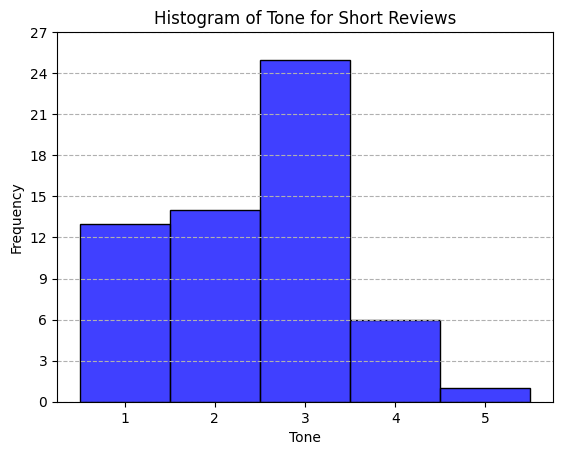

In [87]:
filtered_data = TargetDf[TargetDf['transformed_review'].str.len() < 20]['Tone']

print('Len of short reviews:', len(filtered_data))

# use sns to create a histogram of the Tone column:
sns.histplot(filtered_data, kde=False, discrete=True, color='blue')

# Adicionar título e rótulos aos eixos
plt.title('Histogram of Tone for Short Reviews')
plt.xlabel('Tone')
plt.ylabel('Frequency')
plt.yticks(range(0, 30, 3))
plt.grid(axis='y', linestyle='--')

# Mostrar o gráfico
plt.show()

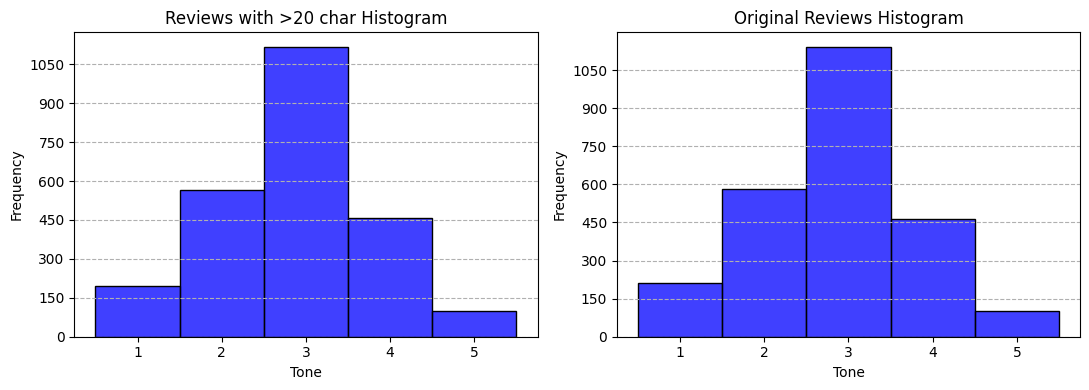

Filtered Dataframe: Tone
3    1117
2     567
4     459
1     197
5     101
Name: count, dtype: int64 

Original Dataframe: Tone
3    1142
2     581
4     465
1     210
5     102
Name: count, dtype: int64


In [121]:
# Only keep reviews with more than 20 characters
TargetDf2 = TargetDf[TargetDf['transformed_review'].str.len() >= 20].copy()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(11, 4))  # 1 row, 2 columns

# First subplot: Reviews with >20 characters
sns.histplot(TargetDf2['Tone'], kde=False, discrete=True, color='blue', ax=axes[0])
axes[0].set_title('Reviews with >20 char Histogram')
axes[0].set_xlabel('Tone')
axes[0].set_ylabel('Frequency')
axes[0].set_yticks(range(0, 1200, 150))
axes[0].grid(axis='y', linestyle='--')

# Second subplot: Original Reviews
sns.histplot(TargetDf['Tone'], kde=False, discrete=True, color='blue', ax=axes[1])
axes[1].set_title('Original Reviews Histogram')
axes[1].set_xlabel('Tone')
axes[1].set_ylabel('Frequency')
axes[1].set_yticks(range(0, 1200, 150))
axes[1].grid(axis='y', linestyle='--')

# Show the plot
plt.tight_layout()
plt.show()

# quantity of tones for both dataframes:
print('Filtered Dataframe:', TargetDf2['Tone'].value_counts(), '\n')
print('Original Dataframe:', TargetDf['Tone'].value_counts())

---
#### OpenAi Call:

In [28]:
# Test Sample
X = TargetDf.sample(1)
X_text = X['review'].values[0]
X_tone = X['Tone'].values[0]
pprint(['Sample Text:', X_text,]) 
print('Tone:', X_tone,'\n')

# ChatGPT:
client = OpenAI(
    api_key=OPENAI_APIKEY,
    project=OPENAI_PROJECT
)

Sample1 = X_text
completion = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content":   "You are a helpful technical assistant,\
                                        specialist in non violent communication, politeness and all communication matters.\
                                        You are rating texts on a scale of 1 to 5 for politeness, from Highly Impolite (1) to Highly Polite (5)."}, 
        {"role": "user", "content":     "I need help with a Peer Review comment.\
                                        in a scale of 1 - 5 classify the comment about it's Politeness.\
                                        How to classify (in a range):\
                                        Highly Impolite (1): Comments containing unnecessarily offensive, sarcastic,\
                                        or disrespectful critiques, using derogatory terms or expressing disdain for the reviewed work.\
                                        Highly Polite (5): Comments explicitly emphasizing positive aspects, using linguistic mitigations,\
                                        direct praise, and respectful language to convey critiques or suggestions.\
                                        Neutral (3) would be a comment that is neither polite nor impolite.\
                                        Bring the rank first, then after a 2 line explanation why, of this comment:"+Sample1},
    ]
)

pprint(completion.choices[0].message.content)

['Sample Text:', 'Are the \'10 random reps" chosen at random?']
Tone: 3 

('4: The comment is phrased as a polite question and serves to seek '
 "clarification without any negative tone. It doesn't contain any offensive "
 'language and would generally be considered as an inquiry for understanding '
 'rather than a critique.')


In [ ]:
#write a file with the response:

with open("resposta1.md", "w") as f:
    f.write(completion.choices[0].message.content)

In [ ]:
# # train test split
# X_train, X_test, y_train, y_test = train_test_split(test[['review','Tone']], test['Tone'], test_size=0.2, random_state=42)

# max_length = X_train['review'].str.len().max()
# print(f"The maximum length of characters is: {max_length}")

# # Lengths of each review
# lengths = X_train['review'].dropna().astype(str).str.len()

In [5]:
# Some visuals

# Plotting the distribution of the sources
PolitenessDF['Venue'].value_counts().plot(title='Sources Freq', kind='bar')
plt.show()

# Tone distribution
plt.figure(figsize=(10, 6))
sns.histplot(PolitenessDF['Tone'], bins=5, fill=True, color='blue', edgecolor='black')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(ticks=[1, 2, 3, 4, 5])
plt.title("Histogram of Politeness Tones", fontsize=16)
plt.xlabel("Tone", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

# Plot tone per venue, stacked
PolitenessDF.groupby(['Venue', 'Tone']).size().unstack().plot(kind='bar', stacked=True, title='Tone per Venue')
plt.show()

# Plot histogram of review lengths
plt.figure(figsize=(10, 6))
sns.histplot(lengths, bins=30, kde=True, color='blue', alpha=0.7)  # Seaborn for enhanced visuals
plt.title("Histogram of Review Lengths", fontsize=16)
plt.xlabel("Review Length (characters)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

clear_output() 

### Pre-Processing

In [6]:
##  TODO: Tirar reviews pequenas

print('Special Characters:', punctuation)

# stop_words = stopwords.words('portuguese')
def preprocess(x: str):
    new_x = x.replace(r'"',' ')
    for c in punctuation:
        new_x = new_x.replace(c,' ')
    pattern = r"""
    [^\w\s]|         # Remove punctuation
    http\S+|         # Remove links
    @\w+|            # Remove mentions
    #\S+|            # Remove hashtags
    \b\w*\d\w*\b|    # Remove words containing numbers
    \s+              # Normalize spaces
    """    
    new_x = re.sub(pattern, ' ', new_x, flags=re.VERBOSE) #removendo pontuação do texto
    return new_x.lower().strip()

df_train = X_train.dropna().copy()
df_test = X_test.dropna().copy()

## Pré-processar datasets de treino e teste
## Dados de treino
df_train['review_original'] = df_train['review']
df_train['review'] = df_train['review'].apply(preprocess)

## Dados de teste
df_test['review_original'] = df_test['review']
df_test['review'] = df_test['review'].apply(preprocess)

Special Characters: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [7]:
## Sample (só para ver o processo mesmo)
df_train[df_train['Tone'] == 5].sample(1)['review_original'].values[0]

'The strength of this paper is that it both gives a more systematic framework for and builds on existing ideas ( character based models , using dictionary definitions ) to implement them as part of a model trained on the end task .'

### Embeddings

In [8]:
## Embbedings pré-treinadas

### HYPERPARAMETERS (from notebooks)
POLITENESS_LEVELS = 5
EPOCHS = 30
MAXLEN = 768 # Since SciBERT returns 768 embeddings vector
LSTM_UNITS = 256
VOCAB_LEN = 1853
EMBEDDING_DIMENSION = 768

import pickle

# LOAD EMBEDS DATASET
def loadPickle(name,is_BiLSTM):
    start_path = '../PolitePEER/'
    if is_BiLSTM:
        LOAD_PATH = start_path+'Tokennized_Processed_X_train-BiLSTM.csv'
        train_embeds = pd.read_csv(LOAD_PATH)
        
        LOAD_PATH = start_path+'Tokennized_Processed_X_test-BiLSTM.csv'
        test_embeds = pd.read_csv(LOAD_PATH)
        
        LOAD_PATH = start_path+'Tokennized_Processed_X_val-BiLSTM.csv'
        val_embeds = pd.read_csv(LOAD_PATH)
        
    else:
        LOAD_PATH = start_path+name+'_train.pickle'
        with open(LOAD_PATH, 'rb') as handle:
            train_embeds = pickle.load(handle)
            handle.close()

        LOAD_PATH = start_path+name+'_test.pickle'
        with open(LOAD_PATH, 'rb') as handle:
            test_embeds = pickle.load(handle)
            handle.close()

        LOAD_PATH = start_path+name+'_val.pickle'
        with open(LOAD_PATH, 'rb') as handle:
            val_embeds = pickle.load(handle)
            handle.close()

    y_train = pd.read_csv(start_path+'y_train.csv')
    y_val = pd.read_csv(start_path+'y_val.csv')
    y_test = pd.read_csv(start_path+'y_test.csv')

    print('\n***** LOADED '+ name+' *****\n')
    print(f'TRAIN SHAPE : {train_embeds.shape}\nTEST SHAPE : {test_embeds.shape}\nVAL SHAPE : {val_embeds.shape}\nY-TRAIN SHAPE : {y_train.shape}\nY-TEST SHAPE : {y_test.shape}\nY-VAL SHAPE : {y_val.shape}')

    return train_embeds, test_embeds, val_embeds, y_train, y_test, y_val

# /kaggle/input/iitpolitenesslevels/SCIBERT_train.pickle
name = ''
train_embeds, test_embeds, val_embeds, y_train, y_test, y_val = loadPickle(name,is_BiLSTM=True)



***** LOADED  *****

TRAIN SHAPE : (4556, 768)
TEST SHAPE : (855, 768)
VAL SHAPE : (284, 768)
Y-TRAIN SHAPE : (4556, 5)
Y-TEST SHAPE : (855, 5)
Y-VAL SHAPE : (284, 5)


In [9]:
train_embeds

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0,0,0,0,0,0,0,0,0,0,...,0,1,210,610,27,41,8,2,209,1
1,0,0,0,0,0,0,0,0,0,0,...,1,252,2,307,5,2,11,2717,15,1
2,0,0,0,0,0,0,0,0,0,0,...,345,12,74,14,207,4,20,7,136,396
3,0,0,0,0,0,0,0,0,0,0,...,54,138,43,84,45,91,1,342,400,731
4,0,0,0,0,0,0,0,0,0,0,...,6,1089,1,1,43,14,191,12,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4551,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2084,6,2085,1
4552,0,0,0,0,0,0,0,0,0,0,...,16,77,4,172,101,1,348,99,627,1
4553,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,62,209,64,1
4554,0,0,0,0,0,0,0,0,0,0,...,0,1,5,76,28,3,179,19,1,1


In [10]:
from transformers import AutoTokenizer, AutoModel

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

sentences = df_train['review'].tolist()

inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")

In [11]:
%%time

import torch

with torch.no_grad():
    outputs = model(**inputs)
    # Extract the CLS token embeddings
    sentence_embeddings = outputs.last_hidden_state[:, 0, :]
    

CPU times: total: 20min 9s
Wall time: 2min 42s


### Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

labels = df_train['Tone'].to_list()

X_train, X_test, y_train, y_test = train_test_split(sentence_embeddings.numpy(), labels, test_size=0.2, random_state=45)

# Initialize and train the classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       0.34      0.41      0.37        34
           2       0.44      0.33      0.38        94
           3       0.59      0.63      0.61       190
           4       0.37      0.45      0.41        62
           5       0.50      0.30      0.38        20

    accuracy                           0.49       400
   macro avg       0.45      0.42      0.43       400
weighted avg       0.50      0.49      0.49       400



In [13]:
type(sentence_embeddings)

torch.Tensor

In [14]:
# Logistic Regression with custom embeddings

labels = df_train['Tone']  # Replace with the correct column name for labels

# Convert DataFrame to NumPy and split features and labels
X_train, X_test, y_train, y_test = train_test_split(
    train_embeds.to_numpy(),  # Features
    labels,  # Labels
    test_size=0.2,  # 20% for testing
    random_state=45  # Ensure reproducibility
)

# Initialize and train the classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [4556, 1999]

`random_state=42`
```txt
                precision    recall  f1-score   support

            1       0.29      0.19      0.23        32
            2       0.34      0.36      0.35        87
            3       0.61      0.68      0.64       194
            4       0.45      0.38      0.41        73
            5       0.36      0.29      0.32        14

    accuracy                            0.50       400
   macro avg        0.41      0.38      0.39       400
weighted avg        0.49      0.50      0.49       400
```

## BiLSTM

In [15]:
labels

print('raw text',ohe_df.sample()['review'].values)

2055    3
1961    4
1864    3
2326    5
461     4
       ..
1638    4
1095    3
1130    3
1294    3
860     4
Name: Tone, Length: 1999, dtype: int64

In [12]:
%%time

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder

# Encode labels to integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(sentence_embeddings, labels, test_size=0.2, random_state=42)

# Custom Dataset class
class PolitenessDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = torch.tensor(embeddings, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

# Create DataLoaders
train_dataset = PolitenessDataset(X_train, y_train)
test_dataset = PolitenessDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define BiLSTM model
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dropout):
        super(BiLSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=n_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Multiply by 2 for bidirectional
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x.unsqueeze(1))  # Add sequence dimension
        lstm_out = self.dropout(lstm_out[:, -1, :])  # Use the last hidden state

        # Fully connected layer
        logits = self.fc(lstm_out)
        return logits

# Model parameters
input_dim = 768  # Dimension of embeddings
hidden_dim = 128  # Number of hidden units
output_dim = len(np.unique(labels))  # Number of politeness levels
n_layers = 2  # Number of LSTM layers
dropout = 0.3  # Dropout rate

# Initialize model, loss, and optimizer
model = BiLSTMClassifier(input_dim, hidden_dim, output_dim, n_layers, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for embeddings, labels in train_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)

            # Forward pass
            outputs = model(embeddings)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

# Train the model
train_model(model, train_loader, criterion, optimizer, device, num_epochs=10)

# Evaluation loop
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for embeddings, labels in test_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)

            # Forward pass
            outputs = model(embeddings)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy: {100 * correct / total:.2f}%")

# Evaluate the model
evaluate_model(model, test_loader, device)



<timed exec>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch [1/10], Loss: 1.3048
Epoch [2/10], Loss: 1.1274
Epoch [3/10], Loss: 1.0527
Epoch [4/10], Loss: 0.9804
Epoch [5/10], Loss: 0.9147
Epoch [6/10], Loss: 0.8971
Epoch [7/10], Loss: 0.7944
Epoch [8/10], Loss: 0.7318
Epoch [9/10], Loss: 0.6748
Epoch [10/10], Loss: 0.5818
Accuracy: 51.75%
CPU times: total: 43.4 s
Wall time: 6.97 s
